In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cascsv/cas.csv


In [44]:
import numpy as np
import pandas as pd
import lime
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from scipy import stats
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,roc_curve,auc,classification_report
from lime import lime_tabular

sns.set_theme()

In [45]:
pd.set_option('display.max_columns',None)

In [46]:
df= pd.read_csv('../input/cascsv/cas.csv')
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,bicycle,bridge,bus,carStationWagon,cliffBank,crashFinancialYear,debris,ditch,fence,flatHill,guardRail,houseOrBuilding,kerb,light,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,roadworks,schoolBus,slipOrFlood,speedLimit,strayAnimal,suv,taxi,trafficSign,trafficControl,train,tree,truck,urban,vehicle,injury
0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0.0,0
1,0.0,0.0,0.0,3.0,0.0,12,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,7,0.0,0.0,0.0,1,0.0,0
2,0.0,0.0,0.0,1.0,1.0,7,0.0,0.0,0.0,0,0.0,0.0,0.0,3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0,0.0,0
3,0.0,0.0,0.0,1.0,1.0,7,0.0,0.0,0.0,0,0.0,0.0,0.0,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0,0.0,0
4,0.0,0.0,0.0,2.0,0.0,4,0.0,0.0,0.0,0,0.0,0.0,0.0,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0.0,0


In [47]:
x = df.iloc[:,:-1]
x.shape

(758006, 36)

In [48]:
y = df.iloc[:, -1:]
y.shape

(758006, 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [50]:
X_train_, y_train_ = X_train.to_numpy(), y_train.to_numpy()
X_test_, y_test_ = X_test.to_numpy(), y_test.to_numpy()

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((606404, 36), (606404, 1), (151602, 36), (151602, 1))

In [52]:
val_mark = int((X_train_.shape[0] / 100) * 10)

In [53]:
X_valid_, y_valid_ = X_train_[-val_mark:], y_train_[-val_mark:]
X_train_, y_train_ = X_train_[:-val_mark], y_train_[:-val_mark]

In [54]:
X_train_.shape, y_train_.shape, X_valid_.shape, y_valid_.shape

((545764, 36), (545764, 1), (60640, 36), (60640, 1))

In [61]:
from keras.utils.np_utils import to_categorical 

y_train_ = to_categorical(y_train_) 
y_test_ = to_categorical(y_test_) 
y_valid_ = to_categorical(y_valid_)

# ANNs

In [62]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train_, y_train_))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid_, y_valid_))

batch_size = 64
train_dataset = (train_loader.shuffle(len(X_train_))
                 .batch(batch_size))

validation_dataset = (validation_loader.shuffle(len(X_valid_))
                      .batch(batch_size))

In [66]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(36,)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 36)                73        
_________________________________________________________________
dense_25 (Dense)             (None, 256)               9472      
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)               

In [71]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                          decay_steps=100000,
                                                          decay_rate=0.96,
                                                          staircase=True)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tfa.metrics.F1Score(num_classes=2)]
              )


checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [73]:
%%time

epochs = 60
model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=epochs,
          shuffle=True,
          verbose=1,
          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/60
8528/8528 [==============================] - 41s 5ms/step - loss: 0.5367 - accuracy: 0.7445 - precision: 0.7445 - recall: 0.7445 - f1_score: 0.5916 - val_loss: 0.5370 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 0.7426 - val_f1_score: 0.5779
Epoch 2/60
8528/8528 [==============================] - 39s 5ms/step - loss: 0.5368 - accuracy: 0.7445 - precision: 0.7445 - recall: 0.7445 - f1_score: 0.5917 - val_loss: 0.5372 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 0.7426 - val_f1_score: 0.5778
Epoch 3/60
8528/8528 [==============================] - 40s 5ms/step - loss: 0.5367 - accuracy: 0.7448 - precision: 0.7448 - recall: 0.7448 - f1_score: 0.5925 - val_loss: 0.5382 - val_accuracy: 0.7421 - val_precision: 0.7421 - val_recall: 0.7421 - val_f1_score: 0.5729
Epoch 4/60
8528/8528 [==============================] - 40s 5ms/step - loss: 0.5364 - accuracy: 0.7447 - precision: 0.7447 - recall: 0.7447 - f1_score: 0.5922 - val_loss: 0.5379 - val_accuracy:

In [74]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
precision = model.history.history['precision']
recall = model.history.history['recall']
accuracy = model.history.history['accuracy']

In [75]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [76]:
def metrics_plot(loss,accuracy,precision,recall):
    plt.plot(loss, label='loss')
    plt.plot(accuracy, label='Accuracy')
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.title('Evaluation metrics', size=20)
    plt.xlabel('Epoch', size=14)
    plt.legend();

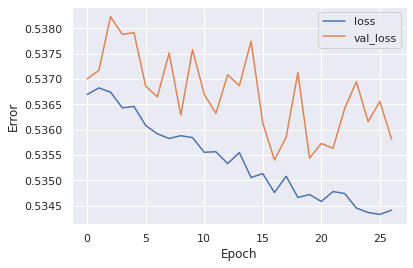

In [77]:
plot_loss(model.history)

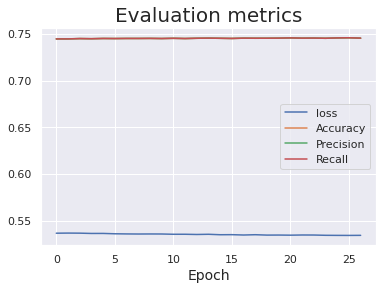

In [78]:
metrics_plot(loss,accuracy,precision,recall)

In [79]:
test_loss, test_accuracy,test_precision,test_recall ,f1_test = model.evaluate(X_test_, y_test_)
train_loss, train_accuracy,train_precision,train_recall, f1_train = model.evaluate(X_train_, y_train_)

17056/17056 [==============================] - 61s 4ms/step - loss: 0.5313 - accuracy: 0.7463 - precision: 0.7463 - recall: 0.7463 - f1_score: 0.5880


In [80]:
test_labels = model.predict(X_test_)
test_class = np.round(test_labels)

In [81]:
cm = confusion_matrix(y_test_,test_class)
cm/300208

ValueError: multilabel-indicator is not supported

In [82]:
print(classification_report(y_test_, test_class, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84    106522
           1       0.75      0.21      0.33     45080

   micro avg       0.74      0.74      0.74    151602
   macro avg       0.75      0.59      0.59    151602
weighted avg       0.75      0.74      0.69    151602
 samples avg       0.74      0.74      0.74    151602



In [83]:
def AUC_ROC(y_test_,test_class):
    fpr, tpr, threshold = roc_curve(y_test_, test_class)
    random_probs = [0 for i in range(len(y_test_))]
    auc_ = auc(fpr, tpr)
    p_fpr, p_tpr, _ = roc_curve(y_test_, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.plot(fpr, tpr, marker='+', label='Neural Network (auc = %0.3f)' % auc_,color='green')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

In [84]:
AUC_ROC(y_test_,test_class)

ValueError: multilabel-indicator format is not supported

In [85]:
def sairam(x):
    output = []
    y = model.predict(x)
    for i in y:
        if i < 0.5:
            output.append([i,1-i])
        else:
            output.append([1-i,i])
    return np.array(output).squeeze()

In [90]:
def LIME(X_train_,y_train_,X_test_,y_test_,idx = 21):
    explainer = lime_tabular.LimeTabularExplainer(X_train_,training_labels=y_train_,feature_names=X_train_.columns.tolist(),feature_selection="lasso_path",class_names=['0', '1'])
    print("Actual :     ", y_test_[idx])
    print("prediction :     ", model.predict(np.expand_dims(X_test_.iloc[idx],axis=0)))
    explanation = explainer.explain_instance(X_test_.iloc[[idx]].values[0], sairam,num_features=len(X_train_.columns))
    explanation.show_in_notebook()

In [91]:
LIME(X_train_,y_train_,X_test_,y_test_,1111)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [89]:
type(y_train_)

numpy.ndarray